In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.contrib import rnn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pylab as plt
import time

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
start_time = time.time()

In [3]:
#Read the training file path
file_dict = {
    'Train':'Processed_Data_Train.csv',
    'Test':'Processed_Data_Test.csv'
}
train_data = pd.read_csv(file_dict['Train'])
test_data = pd.read_csv(file_dict['Test'])

In [4]:
def parse_fl(data):
    # This function mainly to transfer the raw csv file to 
    # training features and labels. 
    
    # Select the features in the input data
    features = data[:, 0:122]
    # Select the labels in the input data
    labels = data[:, 122]
    #trans the label from text to

    return features, labels

In [5]:

train_data = train_data.values
test_data = test_data.values

In [6]:
train_features, train_labels = parse_fl(train_data)
test_features, test_labels = parse_fl(test_data)

In [7]:
# Prepare the training features and labels 
train_Features, train_Labels = parse_fl(train_data)
test_Features, test_Labels = parse_fl(test_data)

In [8]:
temp_labels = []

for i in range(len(train_Labels)):
    if (train_Labels[i] == 1):
        temp_labels.append([1, 0])
    else:
        temp_labels.append([0, 1])

train_Labels = temp_labels
train_Labels = np.array(train_Labels)

In [9]:
temp_labels = []

for i in range(len(test_Labels)):
    if (test_Labels[i] == 1):
        temp_labels.append([1, 0])
    else:
        temp_labels.append([0, 1])

test_Labels = temp_labels
test_Labels = np.array(test_Labels)

In [10]:
learning_rate = 0.01
n_classes = 2
display_step = 10
training_cycles = 100
hidden_units = 20
input_features = 122
time_steps = 1

In [11]:
newtrain_X = train_Features.reshape(len(train_Features), time_steps, -1)
newtrain_Y = train_Labels.reshape(len(train_Labels), n_classes)

newtest_X = test_Features.reshape(len(test_Features), time_steps, -1)
newtest_Y = test_Labels.reshape(len(test_Labels), n_classes)

In [12]:
x = tf.placeholder(tf.float32, [None, time_steps, input_features], name='x-input')
y = tf.placeholder(tf.float32, [None, n_classes], name='y-input')

In [13]:
weight = tf.Variable(tf.random_normal([hidden_units, n_classes]), name='weight')
bias = tf.Variable(tf.random_normal(shape=[n_classes]), name='bias')

In [14]:
cell = tf.contrib.rnn.BasicRNNCell(hidden_units)
init_state = cell.zero_state(len(newtrain_X), dtype=tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
results = tf.matmul(outputs[-1], weight) + bias

In [15]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=results, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [16]:
correct_pred = tf.equal(tf.argmax(results, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float64))

In [17]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [18]:
for i in range (training_cycles):
    _,c = sess.run([optimizer,cost], feed_dict = {x:newtrain_X, y:newtrain_Y})
    
    if (i) % display_step == 0:
        print ("Cost for the training cycle : ",i," : is : ",sess.run(cost, feed_dict ={x :newtrain_X,y:newtrain_Y}))

Cost for the training cycle :  0  : is :  0.54928166
Cost for the training cycle :  10  : is :  0.1448914
Cost for the training cycle :  20  : is :  0.13370349
Cost for the training cycle :  30  : is :  0.12010256
Cost for the training cycle :  40  : is :  0.10697693
Cost for the training cycle :  50  : is :  0.097096846
Cost for the training cycle :  60  : is :  0.09130752
Cost for the training cycle :  70  : is :  0.08715257
Cost for the training cycle :  80  : is :  0.08426537
Cost for the training cycle :  90  : is :  0.08176539


In [19]:
print('Training time is: %d sec' % (time.time() - start_time))

Training time is: 38 sec


In [20]:
print(newtrain_X.shape)
print(newtrain_Y.shape)
print(newtest_X.shape)
print(newtest_Y.shape)

(125973, 1, 122)
(125973, 2)
(22543, 1, 122)
(22543, 2)


In [27]:
correct = tf.equal(tf.argmax(results, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))*100

print('Accuracy on the overall test set is :',accuracy.eval({x:newtest_X, y:newtest_Y}),'%')

Accuracy on the overall test set is : 75.78406 %


confusion matrix 
 [[8093 4740]
 [ 719 8991]]


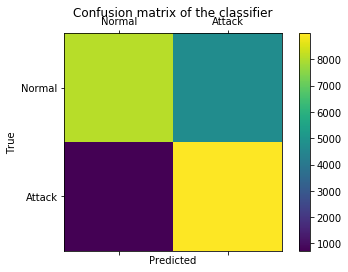

In [28]:
# tf.argmax = Returns the index with the largest value across axes of a tensor.
# Therefore, we are extracting the final labels => '1 0' = '1' = Normal (and vice versa)
# Steps to calculate the confusion matrix

pred_class = sess.run(tf.argmax(results,1),feed_dict = {x:newtest_X,y:newtest_Y})
labels_class = sess.run(tf.argmax(y,1),feed_dict = {x:newtest_X,y:newtest_Y})
conf = tf.contrib.metrics.confusion_matrix(labels_class,pred_class,dtype = tf.int32)
ConfM = sess.run(conf, feed_dict={x:newtest_X,y:newtest_Y})
print ("confusion matrix \n",ConfM)

#Plotting the Confusion Matrix
labels = ['Normal', 'Attack']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ConfM)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
# Calculating Accuracy through another procedure
n = tf.cast(labels_class,tf.int64)
newaccuracy = tf.contrib.metrics.accuracy(pred_class,n)
print ("accuracy calcualted using tf.contrib", sess.run (newaccuracy, feed_dict = {x:newtest_X,y:newtest_Y}))

#Calculations performed manually for other metrics
TP = conf[0,0]
FN = conf [0,1]
FP = conf[1,0]
TN = conf[1,1]

AccConf = (TP+TN)/(TP+FP+TN+FN)
print ("Accuracy calculated manually through confusion matrix", sess.run (AccConf, feed_dict = {x:newtest_X,y:newtest_Y}))

# Precision
Precision = TP/(TP+FP)
print ("Precision \n",sess.run(Precision,feed_dict ={x:newtest_X,y:newtest_Y}))

#Recall also known as Sensitivity
Recall = TP/(TP+FN)
print ("Recall (DR) - Sensitivity [True Positive Rate]\n", sess.run(Recall,feed_dict={x:newtest_X,y:newtest_Y}))

# Specificity

Specificity = TN/(TN+FP)
print ("Specificity \n", sess.run(Specificity,feed_dict={x:newtest_X,y:newtest_Y}))

#F score
FScore = 2*((Precision*Recall)/(Precision+Recall))
print ("F1 Score is \n",sess.run(FScore,{x:newtest_X,y:newtest_Y}))

#False Alarm Rate
FAR = FP/(FP+TN)
print ("False Alarm Rate also known as False Positive Rate \n",sess.run(FAR,feed_dict ={x:newtest_X,y:newtest_Y}))

#Efficiency
Efficiency = Recall/FAR
print("Efficincy is \n",sess.run(Efficiency,feed_dict = {x:newtest_X,y:newtest_Y}))

accuracy calcualted using tf.contrib 0.7578406
Accuracy calculated manually through confusion matrix 0.7578405713525262
Precision 
 0.918406718111666
Recall (DR) - Sensitivity [True Positive Rate]
 0.630639756876802
Specificity 
 0.9259526261585994
F1 Score is 
 0.7477939477939479
False Alarm Rate also known as False Positive Rate 
 0.07404737384140062
Efficincy is 
 8.516706591479482
